# Sentiment Analyse von diversen Reviewdaten durch die Nutzung von Wordembeddings und LSTM

## Zielsetzung: 
In diesem Notebook untersuchen wir, ob moderne Methoden wie Word Embedding und LSTMs unsere Genauigkeit weiter verbessern können. Hierfür verwenden wir erneut die Kombination aus McDonald's und IMDB-Bewertungen.

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers
from utils.text_utils import clean_text
from utils.plot_utils import plot_history_metrics

In [2]:
%pip install kaggle

/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Note: you may need to restart the kernel to use updated packages.


## Reduzierte Ausführungszeit durch lokale Ausführung
Da nicht jeder über eine leistungsstarke Grafikkarte mit GPU-Unterstützung verfügt, kann die Ausführung von LSTMs zeitaufwändig sein. Eine effektive Alternative zur lokalen Ausführung bietet Google Colab. Dieser Dienst ermöglicht die kostenlose Ausführung des Codes mit GPU-Unterstützung. Obwohl die Authentifizierung bei Diensten wie Kaggle etwas komplexer sein kann, haben wir in den Notebooks Tools integriert, die eine einfache Authentifizierung in Google Colab ermöglichen.

## Authentifizierung bei Kaggle
Navigieren Sie zu https://www.kaggle.com. Gehen Sie dann zu Ihrem [Benutzerprofils](https://www.kaggle.com/me/account) und wählen Sie "API-Token erstellen" aus. Dadurch wird die Datei kaggle.json heruntergeladen, die Ihre API-Zugangsdaten enthalten.

Führen Sie anschließend die nachstehende Zelle aus, um kaggle.json in Ihrer Colab-Laufzeit hochzuladen.

In [3]:
# from google.colab import files
    
# uploaded = files.upload()

# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#             name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Herunterladen der Daten

In [4]:
import os

# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip

Unzipping McDonalds dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip


Unzipping IMDB dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip


## Prozessierung der Daten
Die Prozessierung wird nicht weiterbeschrieben, weil sie identisch zum letzten Notebook ist. 

In [5]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')

In [6]:
df_mc = df_mc[['review', 'rating']]
df_imdb = df_imdb[['review', 'sentiment']]

In [7]:
df_mc.head()

,review,rating
0,Why does it look like someone spit on my food?...,1 star
1,It'd McDonalds. It is what it is as far as the...,4 stars
2,Made a mobile order got to the speaker and che...,1 star
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,"I repeat my order 3 times in the drive thru, a...",1 star


In [8]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df_mc['review'] = df_mc['review'].apply(clean_text)
df_imdb['review'] = df_imdb['review'].apply(clean_text)    

In [10]:
df_mc.head()

,review,rating
0,why does it look like someone spit on my food\...,1 star
1,it would mcdonalds it is what it is as far as ...,4 stars
2,made a mobile order got to the speaker and che...,1 star
3,my mc crispy chicken sandwich was customer se...,5 stars
4,i repeat my order 3 times in the drive thru an...,1 star


In [11]:
df_imdb.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter matteis love in the time of money is a ...,positive


In [12]:
df_mc = df_mc[df_mc['rating'] != '3 stars']
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,label_mc)

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

## Generierung eines Sequence Models aus den Daten
### 1. Text zu Intergers
Um ein Sequenze Model zu erstellen werden die Input Samples als erstes in Sequenzen von Integer Indizes konvertiert, wobei ein Integer ein Wort repräsentiert.  

In [13]:
max_length = 600
max_tokens = 20000
text_vectorization_sequence = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
)
text_vectorization_sequence.adapt(train_data)
text_vectorization_sequence.adapt(test_data)

int_train_ds = text_vectorization_sequence(train_data)

int_test_ds = text_vectorization_sequence(test_data)

vocabulary = np.array(text_vectorization_sequence.get_vocabulary())

print("Vocabulary size: {}".format(len(vocabulary)))
print("Vocabulary content:\n {}".format(vocabulary[:20]))

Vocabulary size: 20000
Vocabulary content:
 ['' '[UNK]' 'the' 'and' 'a' 'of' 'is' 'to' 'it' 'in' 'i' 'this' 'that'
 'not' 'was' 'for' 'as' 'with' 'but' 'movie']


## 2. Konvertierung der Integer Sequenzen in Vektor Sequenzen
### 2a. One Hot Encoding
Ein erster Ansatz zur Konvertierung der Integersequenzen in Vektorsequenzen war die Verwendung des One-Hot-Encodings. Dabei würde jede Dimension ein Wort im Vokabular repräsentieren. 

In [14]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
___________________________________________________

In [15]:
callbacks = [
  keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

oh_history = model.fit(int_train_ds, train_label, epochs=10,validation_split=0.2,callbacks=callbacks, verbose=1)


Epoch 1/10
1572/1572 [==============================] - 118s 73ms/step - loss: 0.4646 - accuracy: 0.7874 - val_loss: 0.3208 - val_accuracy: 0.8741
Epoch 2/10
1572/1572 [==============================] - 118s 75ms/step - loss: 0.3097 - accuracy: 0.8801 - val_loss: 0.2900 - val_accuracy: 0.8882
Epoch 3/10
1572/1572 [==============================] - 118s 75ms/step - loss: 0.2700 - accuracy: 0.8972 - val_loss: 0.3039 - val_accuracy: 0.8736
Epoch 4/10
1572/1572 [==============================] - 117s 75ms/step - loss: 0.2479 - accuracy: 0.9082 - val_loss: 0.2735 - val_accuracy: 0.8971
Epoch 5/10
1572/1572 [==============================] - 117s 75ms/step - loss: 0.2326 - accuracy: 0.9156 - val_loss: 0.2796 - val_accuracy: 0.8965
Epoch 6/10
1572/1572 [==============================] - 116s 74ms/step - loss: 0.2194 - accuracy: 0.9232 - val_loss: 0.2705 - val_accuracy: 0.8931
Epoch 7/10
1572/1572 [==============================] - 118s 75ms/step - loss: 0.2022 - accuracy: 0.9274 - val_loss: 0

In [16]:
model.evaluate(int_test_ds, test_label)

492/492 [==============================] - 21s 42ms/step - loss: 0.2566 - accuracy: 0.9023


[0.25659847259521484, 0.902265191078186]

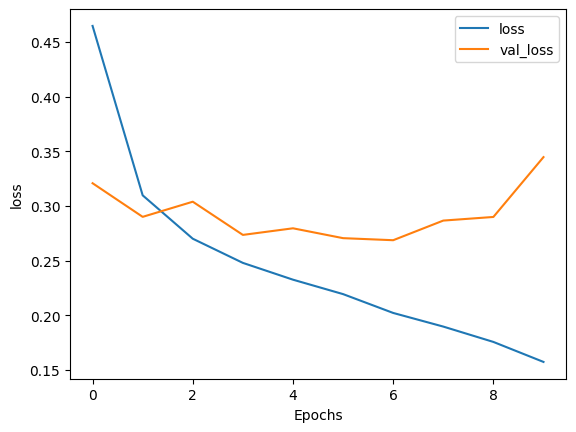

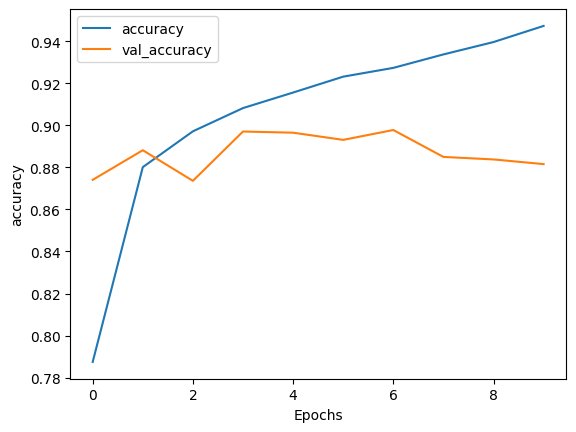

In [17]:
plot_history_metrics(oh_history, ["loss", "accuracy"])

Diese Model trainiert nur sehr langsam oder stürzt bei manchen PCs sogar ab, weil zu wenig RAM vorhanden ist. One-Hot Encoding ist klar die falsche Lösung um diese Daten in ein Vektorsequenzen zu transformieren.

### 2b. Word-Embeddings
Ein wesentliches Problem des One-Hot-Encodings war, dass die Repräsentation keine Zusammenhänge zwischen den Wörtern abbildete, da sie unabhängig voneinander waren. Jedoch sind Wörter nicht unabhängig voneinander. Um diese Abhängigkeiten darzustellen, können Word Embeddings verwendet werden. In diesen reflektieren die geometrischen Beziehungen zwischen zwei Vektoren auch ihre semantischen Beziehungen. 

Keras stellt uns bereits Embedding-Layer zur Verfügung, die wir nutzen können. Diese funktionieren so, dass ihre Gewichtungen (ein internes Dictionary von Token-Vektoren) anfangs zufällig sind. Während des Trainings werden diese Vektoren durch Backpropagation schrittweise angepasst. Die Struktur dieser Layer kann dann von anderen Layern genutzt werden, um die Leistung zu verbessern.

In [18]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

## Was ist ein RNNs und LSTMs?
RNNs (Recurrent Neural Networks) sind eine Art von neuronalen Netzwerken, die speziell für die Verarbeitung von sequenziellen Daten entwickelt wurden. Im Gegensatz zu herkömmlichen neuronalen Netzwerken können RNNs Informationen über vergangene Zustände behalten und sie in die Berechnung aktueller Schritte einbeziehen.

Durch ihre Fähigkeit, Kontextinformationen über vergangene Eingaben zu erfassen, können RNNs komplexe Abhängigkeiten in sequenziellen Daten modellieren und lernen. Deshalb können sie auch auf NLP Probleme angewendet werden.

Eine der großen Herausforderungen von RNNs ist das "Vanishing Gradient Problem". Es beschreibt das Verschwinden oder die Explosion des Gradienten während des Backpropagation-Algorithmus, der zum Trainieren des Netzwerks verwendet wird.

Das Vanishing Gradient Problem tritt auf, wenn die Ableitungsfunktionen in den Schichten des Netzwerks Werte kleiner als 1 haben, insbesondere wenn sie nahe bei 0 liegen. In diesem Fall wird der Gradient in jeder Schicht während der Rückpropagierung mit jedem Schritt weiter multipliziert, wodurch er exponentiell kleiner wird. Als Ergebnis erhalten die Gewichte in den ersten Schichten des Netzwerks nur sehr kleine Aktualisierungen, was zu langsamerem oder gar keinem Lernen führen kann. Dies beeinträchtigt insbesondere RNNs, die auf lange Sequenzen angewendet werden.

LSTMs reduzieren dieses Problem durch ihre Architektur. Im Vergleich zu herkömmlichen RNNs verwenden LSTMs einen zusätzlichen Zellzustand, der als "Gedächtnis" fungiert und Informationen über längere Sequenzen hinweg speichert. Der Zellzustand ermöglicht es den LSTMs, wichtige Informationen beizubehalten und irrelevante Informationen zu verwerfen, was dazu beiträgt, das Verschwinden des Gradienten zu verhindern.

In [19]:
callbacks = [
  keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

emb_history = model.fit(int_train_ds, train_label,validation_split=0.2
, epochs=10,
 callbacks=callbacks, verbose=1)

Epoch 1/10
1572/1572 [==============================] - 103s 64ms/step - loss: 0.4125 - accuracy: 0.8154 - val_loss: 0.2969 - val_accuracy: 0.8825
Epoch 2/10
1572/1572 [==============================] - 62s 40ms/step - loss: 0.2984 - accuracy: 0.8834 - val_loss: 0.2850 - val_accuracy: 0.8929
Epoch 3/10
1572/1572 [==============================] - 58s 37ms/step - loss: 0.2554 - accuracy: 0.9042 - val_loss: 0.2598 - val_accuracy: 0.8983
Epoch 4/10
1572/1572 [==============================] - 55s 35ms/step - loss: 0.2297 - accuracy: 0.9156 - val_loss: 0.2816 - val_accuracy: 0.8926
Epoch 5/10
1572/1572 [==============================] - 56s 35ms/step - loss: 0.2082 - accuracy: 0.9239 - val_loss: 0.2577 - val_accuracy: 0.8964
Epoch 6/10
1572/1572 [==============================] - 56s 36ms/step - loss: 0.1878 - accuracy: 0.9345 - val_loss: 0.2598 - val_accuracy: 0.9085
Epoch 7/10
1572/1572 [==============================] - 59s 38ms/step - loss: 0.1673 - accuracy: 0.9424 - val_loss: 0.2649 

In [20]:
model.evaluate(int_test_ds, test_label)

492/492 [==============================] - 7s 14ms/step - loss: 0.2513 - accuracy: 0.8987


[0.25133806467056274, 0.8987019658088684]

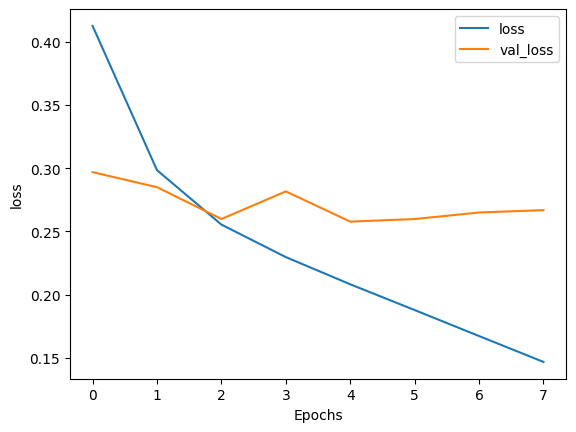

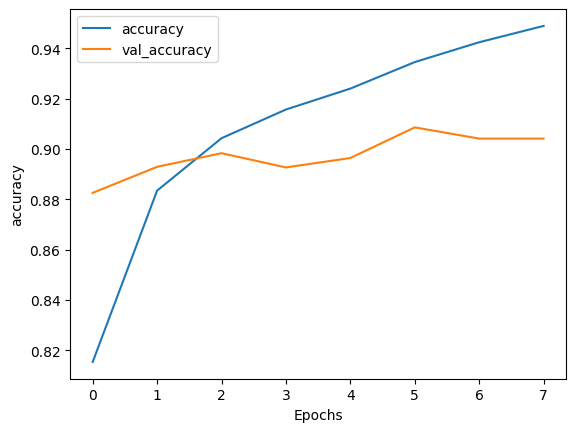

In [21]:
plot_history_metrics(emb_history, ['loss', 'accuracy'])

#### Warum sind die Ergbnisse signfikant schlechter als mit dem Bag of Words Model? 
Wir sind noch ein Stück von den Ergebnissen des simpleren Bigram-Modells entfernt. Ein Teil des Grundes dafür ist einfach, dass das Modell etwas weniger Daten betrachtet: Das Bigram-Modell verarbeitete vollständige Bewertungen, während unser Sequenzmodell Sequenzen nach 600 Wörtern abschneidet.
Es gibt hierfür aber noch weitere Gründe. Diese werden im letzen Abschnitt des Notebooks erläutert.

#### Ansehen der Word-Embedding Daten
Um die entstandenen geometrischen Beziehungen zu betrachten, die die semantischen Beziehungen zwischen den Vektoren zeigen, kann das Tool "TensorFlow Projector" verwendet werden. Dazu müssen lediglich die Daten aus dem nächsten Code-Block über den folgenden Link hochgeladen werden: http://projector.tensorflow.org/

In [22]:
import io
weights = model.layers[1].get_weights()[0]
vocab = text_vectorization_sequence.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## Nutzen von vordefinierten Embeddings
Nun nutzen wir die [GloVe](https://github.com/stanfordnlp/GloVe) embeddings von der Stanford NLP Arbeitsgruppe.
Es wird das 100d Model genutzt welches auf Kaggle ([hier](https://www.kaggle.com/datasets/anindya2906/glove6b)) heruntergeladen werden kann. Anschliessend muss dieses in den `embeddings` ordner gelegt werden, sodass `embeddings/glove.6B.100d.txt` zur Verfuegung steht.

In [23]:
from utils.file_utils import read_embeddings
filepath = './embeddings/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = read_embeddings(filepath)

In [24]:
test_word = 'hello'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"Vektor des Wortes '{test_word}' sieht wie folgt aus:\n\n{test_vector}")

Vektor des Wortes 'hello' sieht wie folgt aus:

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.273

In [25]:
print(f"Vector shape: {test_vector.shape}")

Vector shape: (100,)


In [26]:
embedding_dim = 100
EMBEDDINGS_MATRIX = np.zeros((max_tokens, embedding_dim))

for i, word in np.ndenumerate(vocabulary):
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [27]:
def create_model(vocab_size, embedding_dim, embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=5,
        restore_best_weights=True)
    
    callbacks = [early_stopping]    

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy']) 

    return model, callbacks

In [28]:
model, callbacks = create_model(max_tokens, embedding_dim, EMBEDDINGS_MATRIX)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

In [29]:
history = model.fit(int_train_ds, train_label, validation_split=0.2, epochs=10, callbacks=callbacks, verbose=1) 

Epoch 1/10
1572/1572 [==============================] - 54s 33ms/step - loss: 0.4886 - accuracy: 0.7703 - val_loss: 0.4127 - val_accuracy: 0.8245
Epoch 2/10
1572/1572 [==============================] - 51s 33ms/step - loss: 0.3817 - accuracy: 0.8351 - val_loss: 0.3355 - val_accuracy: 0.8590
Epoch 3/10
1572/1572 [==============================] - 51s 33ms/step - loss: 0.3409 - accuracy: 0.8547 - val_loss: 0.3661 - val_accuracy: 0.8461
Epoch 4/10
1572/1572 [==============================] - 50s 32ms/step - loss: 0.3159 - accuracy: 0.8678 - val_loss: 0.2959 - val_accuracy: 0.8744
Epoch 5/10
1572/1572 [==============================] - 49s 31ms/step - loss: 0.2987 - accuracy: 0.8765 - val_loss: 0.2879 - val_accuracy: 0.8801
Epoch 6/10
1572/1572 [==============================] - 52s 33ms/step - loss: 0.2854 - accuracy: 0.8830 - val_loss: 0.3012 - val_accuracy: 0.8743
Epoch 7/10
1572/1572 [==============================] - 51s 32ms/step - loss: 0.2728 - accuracy: 0.8878 - val_loss: 0.2749 -

In [30]:
model.evaluate(int_test_ds, test_label)

492/492 [==============================] - 6s 13ms/step - loss: 0.2629 - accuracy: 0.8915


[0.26294809579849243, 0.891511857509613]

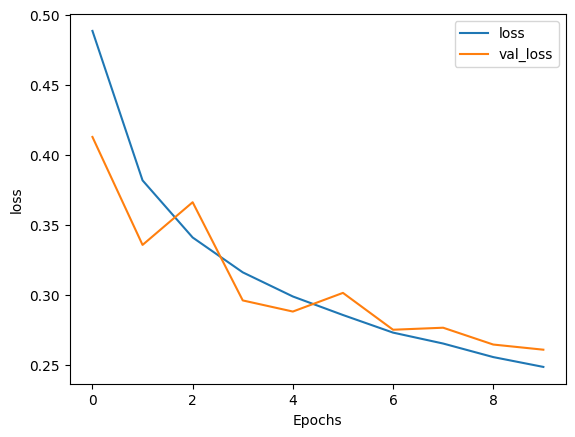

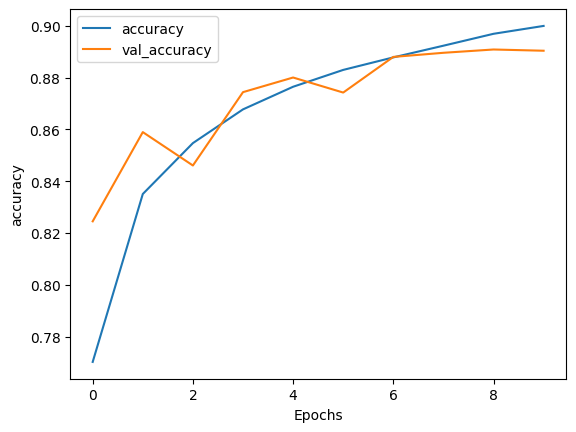

In [31]:
plot_history_metrics(history, ['loss', 'accuracy'])

## Warum performen die Sequence Model Lösungen nicht unbedingt besser als die bag of Gram Lösungen?
Obwohl die Bag-of-Words-Methode (BoW) nicht mehr die aktuellste Technologie im Natural Language Processing (NLP) ist, bietet sie für bestimmte Textklassifikationsaufgaben weiterhin die überlegene Lösung. 

Das Google Keras Team empfiehlt als Heuristik, das Verhältnis zwischen der Anzahl der Samples in den Trainingsdaten und der durchschnittlichen Anzahl von Wörtern pro Sample zu betrachten. Wenn dieses Verhältnis über 1500 liegt, ist ein Sequence Model die geeignetere Lösung, während bei einem Verhältnis unter 1500 ein Bigram die bessere Wahl ist.

In [32]:
word_counts = []
for item in data: 
    words = item.split()
    word_counts.append(len(words))

word_counts =  np.array(word_counts)


ratio = len(word_counts) / word_counts.mean()
print(ratio)



508.97547249303597


Bei unseren Daten ist diese Ratio 962, deshalb können wir klar sagen, dass Bigrams der bessere Ansatz für die Sentiment Analyse von Reviews dieser Wortanzahl ist. 

Durch das Hinzufügen der IMDB-Trainingsdaten haben wir versucht, ein allgemeingültigeres Modell zu erstellen. Jedoch ist diese Form der Generalisierung mit einem Bigram-Ansatz nur bis zu einer bestimmten Menge an Trainingsdaten effektiv. Wenn wir unsere Trainingsdaten um weitere 500.000 Amazon Reviews erweitern würden und sich der Durchschnitt (Mean) dabei nicht ändern würde, wäre die Verwendung von Sequence Encodings die richtige Wahl.

In [33]:
withAmazon = (len(word_counts) + 500000 ) /  word_counts.mean()
print(withAmazon)

3747.639427372493
